In [15]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from torch.optim import Optimizer
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rc('font', size=30)

In [3]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [4]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()
    total_loss = 0

    for i, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        loss.backward()
        print(f'{loss.item():.5f}')
        optimizer.step()

    return total_loss / len(data_loader)

In [5]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()
    total_loss = 0

    for i, (x, y) in enumerate(data_loader):
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()

    return total_loss / len(data_loader)

In [6]:
def count_parameters_conv(in_channels: int,
                          out_channels: int,
                          kernel_size: int,
                          bias: bool):
    if bias == True:
        return (in_channels * kernel_size ** 2 + 1) * out_channels

    else:
        return (in_channels * kernel_size ** 2) * out_channels

In [7]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [8]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [9]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

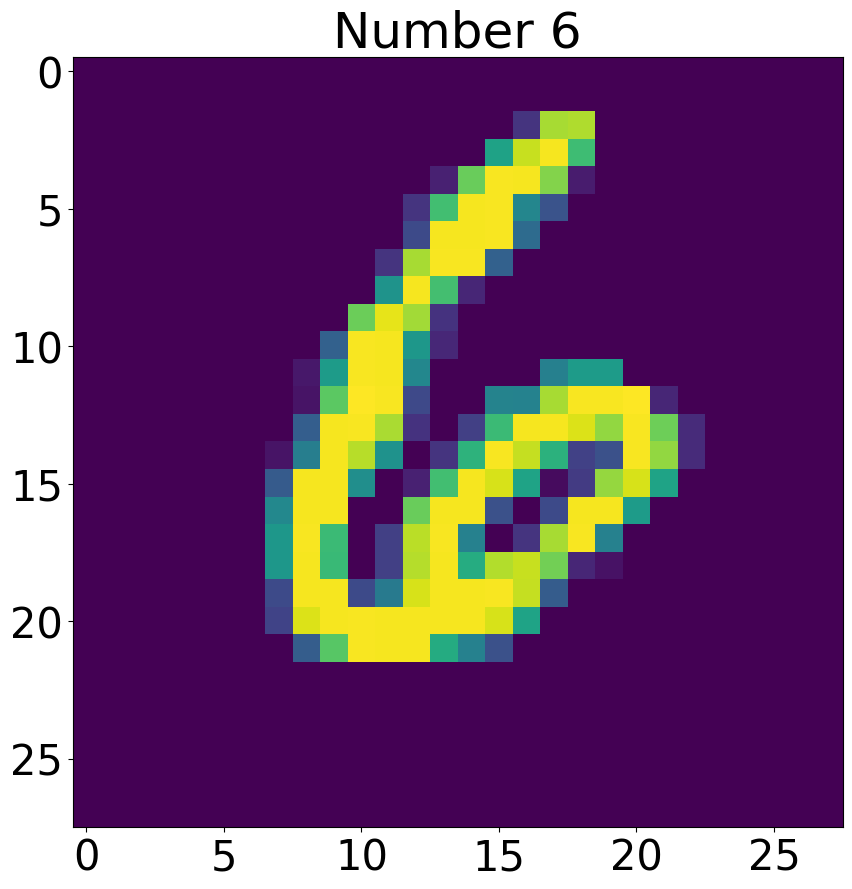

In [10]:
plt.figure(figsize=(10, 10))
plt.title(f'Number {mnist_train[13][1]}')
plt.imshow(mnist_train[13][0][0])

plt.show()

In [12]:
def create_conv_model():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),
        nn.Linear(4 * 4 * 64, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )


In [13]:
model = create_conv_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

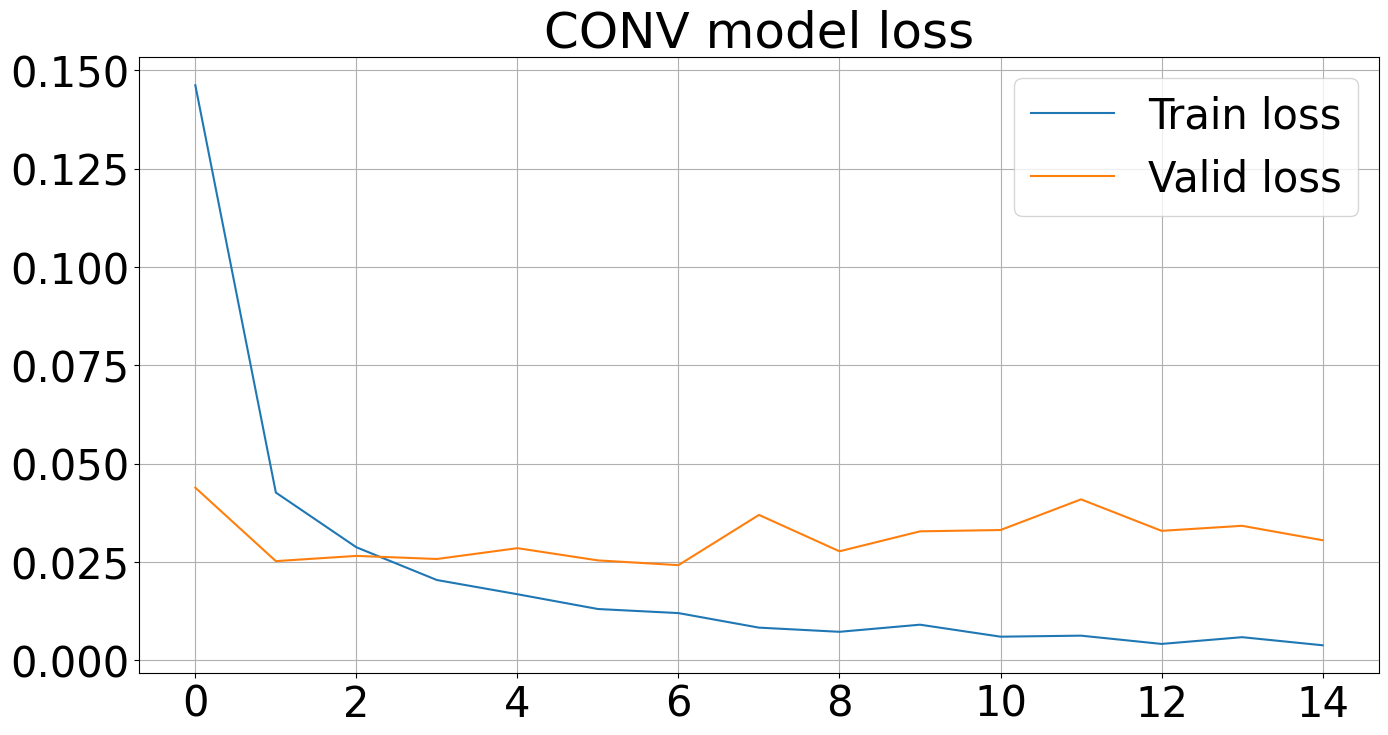

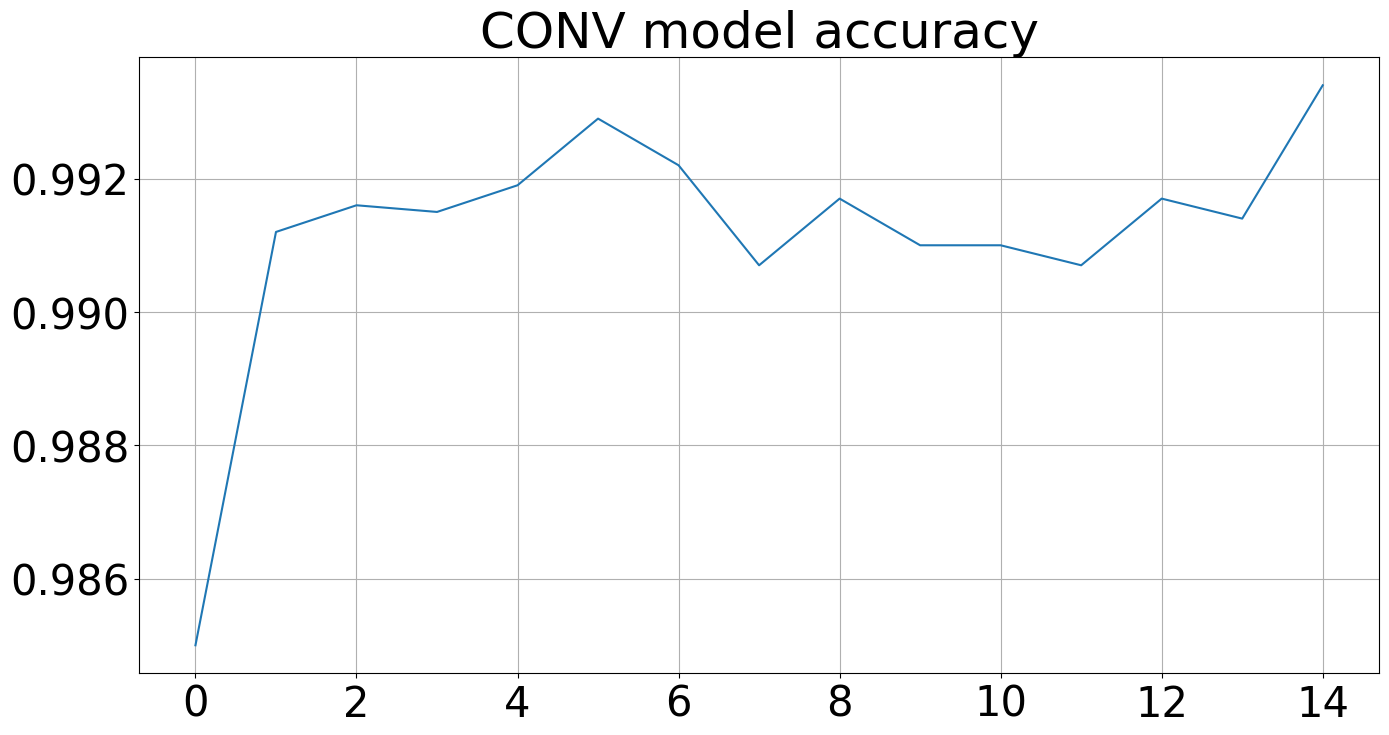

Total training and evaluation time 395.56080


In [14]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    valid_loss = evaluate(model, valid_loader, loss_fn)

    # Compute validation accuracy
    correct = 0
    total = 0
    with torch.inference_mode():
        for x, y in valid_loader:
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    

    valid_accuracy = correct / total
    
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')